In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/shelter-animal-outcomes/sample_submission.csv.gz
/kaggle/input/shelter-animal-outcomes/test.csv.gz
/kaggle/input/shelter-animal-outcomes/train.csv.gz


In [2]:
train_df = pd.read_csv('/kaggle/input/shelter-animal-outcomes/train.csv.gz',parse_dates=['DateTime'])
test_df = pd.read_csv('/kaggle/input/shelter-animal-outcomes/test.csv.gz',parse_dates=['DateTime'])

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 10 columns):
AnimalID          26729 non-null object
Name              19038 non-null object
DateTime          26729 non-null datetime64[ns]
OutcomeType       26729 non-null object
OutcomeSubtype    13117 non-null object
AnimalType        26729 non-null object
SexuponOutcome    26728 non-null object
AgeuponOutcome    26711 non-null object
Breed             26729 non-null object
Color             26729 non-null object
dtypes: datetime64[ns](1), object(9)
memory usage: 2.0+ MB


In [4]:
test_df.head()

,ID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,1,Summer,2015-10-12 12:15:00,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White
1,2,Cheyenne,2014-07-26 17:59:00,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan
2,3,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby
3,4,Pongo,2013-12-28 18:12:00,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor
4,5,Skooter,2015-09-24 17:59:00,Dog,Neutered Male,2 years,Miniature Poodle Mix,White


# Checking Type of our dependent variable

In [5]:
train_df.OutcomeType.value_counts()

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: OutcomeType, dtype: int64

Seems like our dependent variable is a categorical variable with 4 different category.

# Now lets check for missing values in our Data

In [6]:
# Missing values
for c in train_df.columns.values.tolist():
    print(c,' ',train_df[c].isnull().sum(),' ',100 * train_df[c].isnull().sum()/len(train_df))

AnimalID   0   0.0
Name   7691   28.77399079651315
DateTime   0   0.0
OutcomeType   0   0.0
OutcomeSubtype   13612   50.92596056717423
AnimalType   0   0.0
SexuponOutcome   1   0.0037412548168655768
AgeuponOutcome   18   0.06734258670358038
Breed   0   0.0
Color   0   0.0


In [7]:
# Missing values
for c in test_df.columns.values.tolist():
    print(c,' ',test_df[c].isnull().sum(),' ',100 * test_df[c].isnull().sum()/len(test_df))

ID   0   0.0
Name   3225   28.151187150837988
DateTime   0   0.0
AnimalType   0   0.0
SexuponOutcome   0   0.0
AgeuponOutcome   6   0.052374301675977654
Breed   0   0.0
Color   0   0.0


# Observation
## We can see that the percent of missing values
1. OutcomeSubtype = 50%
2. Name = 28%
3. AgeuponOutcome = 6%
4. SexuponOutcome =0.3%
## So Next Question is How we deal with missing values in each column

1. OutcomeSubtype = We dont need this column becuase it is not present in test set
2. Name = Name does not matter it is kind of id
3. AgeuponOutcome = We will convert this into months and for missing samples we will set it to 0
4. SexuponOutcome = very less so set it to unknowm

Convert Age in months from different format

In [8]:
def get_age_in_monthe(x):
    x = str(x)
        
    if x == 'nan':
        return 0
    n = int(x.split()[0])
    if x.find('year') > -1:
        return  n*12
    if x.find('month') >-1:
        return n
    if x.find('week') >-1:
        return n/4
    if x.find('day') > -1:
        
        return n/30
    
    return 0;

train_df.AgeuponOutcome = train_df.AgeuponOutcome.apply(get_age_in_monthe)
test_df.AgeuponOutcome = test_df.AgeuponOutcome.apply(get_age_in_monthe)
    

In [9]:
# drop not required features from train and test
train_df.drop(['Name','OutcomeSubtype','AnimalID'],axis=1,inplace=True)
test_df.drop(['Name','ID'],axis=1,inplace=True)

In [10]:
train_df.head()

,DateTime,OutcomeType,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,2014-02-12 18:22:00,Return_to_owner,Dog,Neutered Male,12.00,Shetland Sheepdog Mix,Brown/White
1,2013-10-13 12:44:00,Euthanasia,Cat,Spayed Female,12.00,Domestic Shorthair Mix,Cream Tabby
2,2015-01-31 12:28:00,Adoption,Dog,Neutered Male,24.00,Pit Bull Mix,Blue/White
3,2014-07-11 19:09:00,Transfer,Cat,Intact Male,0.75,Domestic Shorthair Mix,Blue Cream
4,2013-11-15 12:52:00,Transfer,Dog,Neutered Male,24.00,Lhasa Apso/Miniature Poodle,Tan


In [11]:
train_df.columns

Index(['DateTime', 'OutcomeType', 'AnimalType', 'SexuponOutcome',
       'AgeuponOutcome', 'Breed', 'Color'],
      dtype='object')

In [12]:
test_df.columns

Index(['DateTime', 'AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Breed',
       'Color'],
      dtype='object')

In [13]:
from fastai import *
from fastai.tabular import *

In [14]:
add_datepart(field_name='DateTime',df=train_df,drop=True)
add_datepart(field_name='DateTime',df=test_df,drop=True)

,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,DateTimeYear,DateTimeMonth,DateTimeWeek,DateTimeDay,DateTimeDayofweek,DateTimeDayofyear,DateTimeIs_month_end,DateTimeIs_month_start,DateTimeIs_quarter_end,DateTimeIs_quarter_start,DateTimeIs_year_end,DateTimeIs_year_start,DateTimeElapsed
0,Dog,Intact Female,10.0,Labrador Retriever Mix,Red/White,2015,10,42,12,0,285,False,False,False,False,False,False,1444652100
1,Dog,Spayed Female,24.0,German Shepherd/Siberian Husky,Black/Tan,2014,7,30,26,5,207,False,False,False,False,False,False,1406397540
2,Cat,Neutered Male,12.0,Domestic Shorthair Mix,Brown Tabby,2016,1,2,13,2,13,False,False,False,False,False,False,1452687600
3,Dog,Intact Male,4.0,Collie Smooth Mix,Tricolor,2013,12,52,28,5,362,False,False,False,False,False,False,1388254320
4,Dog,Neutered Male,24.0,Miniature Poodle Mix,White,2015,9,39,24,3,267,False,False,False,False,False,False,1443117540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11451,Cat,Neutered Male,2.0,Domestic Shorthair Mix,Black,2014,7,28,8,1,189,False,False,False,False,False,False,1404831000
11452,Cat,Intact Female,0.5,Domestic Shorthair Mix,Blue,2014,10,43,21,1,294,False,False,False,False,False,False,1413896220
11453,Cat,Intact Female,12.0,Domestic Shorthair Mix,Calico,2014,9,40,29,0,272,False,False,False,False,False,False,1411981200
11454,Dog,Neutered Male,72.0,German Shepherd Mix,Black/Tan,2015,9,36,5,5,248,False,False,False,False,False,False,1441473360


In [15]:
cat_names = ['AnimalType','SexuponOutcome','Breed','Color', 'DateTimeYear', 'DateTimeMonth', 'DateTimeWeek',
       'DateTimeDay', 'DateTimeDayofweek', 'DateTimeDayofyear',
       'DateTimeIs_month_end', 'DateTimeIs_month_start',
       'DateTimeIs_quarter_end', 'DateTimeIs_quarter_start',
       'DateTimeIs_year_end', 'DateTimeIs_year_start']
cont_names = ['AgeuponOutcome', 'DateTimeElapsed']
dep_var = 'OutcomeType'

train_df = train_df[cat_names+cont_names+[dep_var]]
test_df = test_df[cat_names+cont_names]

In [16]:
# Missing values
for c in train_df.columns.values.tolist():
    print(c,' ',train_df[c].isnull().sum(),' ',100 * train_df[c].isnull().sum()/len(train_df))

AnimalType   0   0.0
SexuponOutcome   1   0.0037412548168655768
Breed   0   0.0
Color   0   0.0
DateTimeYear   0   0.0
DateTimeMonth   0   0.0
DateTimeWeek   0   0.0
DateTimeDay   0   0.0
DateTimeDayofweek   0   0.0
DateTimeDayofyear   0   0.0
DateTimeIs_month_end   0   0.0
DateTimeIs_month_start   0   0.0
DateTimeIs_quarter_end   0   0.0
DateTimeIs_quarter_start   0   0.0
DateTimeIs_year_end   0   0.0
DateTimeIs_year_start   0   0.0
AgeuponOutcome   0   0.0
DateTimeElapsed   0   0.0
OutcomeType   0   0.0


In [17]:
# Missing values
for c in test_df.columns.values.tolist():
    print(c,' ',test_df[c].isnull().sum(),' ',100 * test_df[c].isnull().sum()/len(test_df))

AnimalType   0   0.0
SexuponOutcome   0   0.0
Breed   0   0.0
Color   0   0.0
DateTimeYear   0   0.0
DateTimeMonth   0   0.0
DateTimeWeek   0   0.0
DateTimeDay   0   0.0
DateTimeDayofweek   0   0.0
DateTimeDayofyear   0   0.0
DateTimeIs_month_end   0   0.0
DateTimeIs_month_start   0   0.0
DateTimeIs_quarter_end   0   0.0
DateTimeIs_quarter_start   0   0.0
DateTimeIs_year_end   0   0.0
DateTimeIs_year_start   0   0.0
AgeuponOutcome   0   0.0
DateTimeElapsed   0   0.0


In [18]:
# setting everything to lowercase
for c in ['AnimalType','SexuponOutcome','Breed','Color']:
    train_df[c] =train_df[c].str.lower()
    test_df[c] = test_df[c].str.lower()

In [19]:
# Adding Sex and State  column
train_df['Sex'] = train_df.SexuponOutcome.str.extract(r'.*?(male|female|unknown)')
test_df['Sex'] = test_df.SexuponOutcome.str.extract(r'.*?(male|female|unknown)')

train_df['State'] = train_df.SexuponOutcome.str.extract(r'(neutered|spayed|intact|unknown).*?')
test_df['State'] = test_df.SexuponOutcome.str.extract(r'(neutered|spayed|intact|unknown).*?')

train_df.drop('SexuponOutcome',axis=1,inplace=True)
test_df.drop('SexuponOutcome',axis=1,inplace=True)

In [20]:
cat_names = ['AnimalType','Sex','State','Breed','Color', 'DateTimeYear', 'DateTimeMonth', 'DateTimeWeek',
       'DateTimeDay', 'DateTimeDayofweek', 'DateTimeDayofyear',
       'DateTimeIs_month_end', 'DateTimeIs_month_start',
       'DateTimeIs_quarter_end', 'DateTimeIs_quarter_start',
       'DateTimeIs_year_end', 'DateTimeIs_year_start']
cont_names = ['AgeuponOutcome', 'DateTimeElapsed']
dep_var = 'OutcomeType'

train_df = train_df[cat_names+cont_names+[dep_var]]
test_df = test_df[cat_names+cont_names]

In [21]:
train_df.OutcomeType = train_df.OutcomeType.astype('category')

In [22]:
catfy =Categorify(cat_names,cont_names)
catfy.apply_train(train_df)
catfy.apply_test(test_df)

# Exploratory Data Analysis

1. Statistical Relationship
2. Catgorical variable 
3. Distibutions

In [23]:
import seaborn as sns
%matplotlib inline

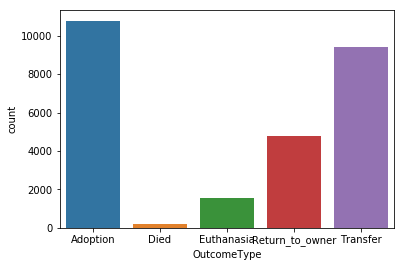

In [24]:
sns.countplot(dep_var,data=train_df)

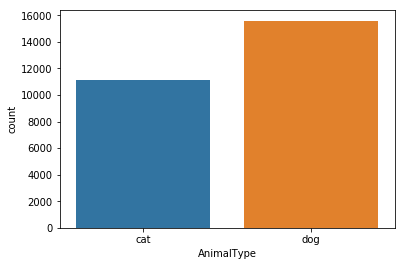

In [25]:
sns.countplot(cat_names[0],data=train_df)

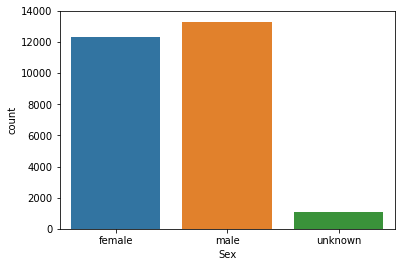

In [26]:
sns.countplot(cat_names[1],data=train_df)

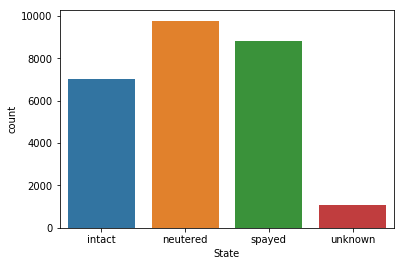

In [27]:
sns.countplot(cat_names[2],data=train_df)

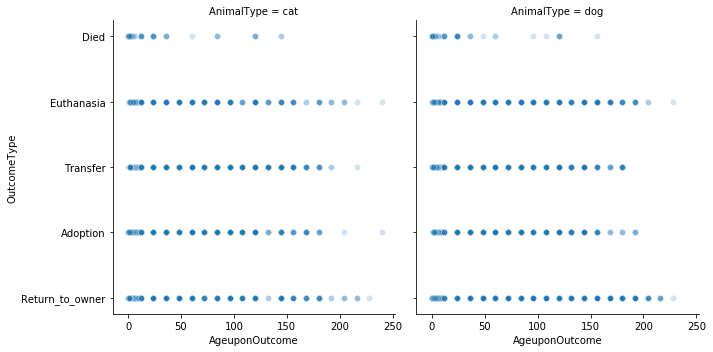

In [28]:
sns.relplot(x='AgeuponOutcome',y=dep_var,data=train_df,col='AnimalType',alpha=.2)

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 

In [30]:
train_x,val_x,train_y,val_y = train_test_split(train_df.drop(dep_var,axis=1),train_df[dep_var],test_size=0.2)

In [31]:
for c in cat_names:
    train_x[c] =train_x[c].cat.codes
    val_x[c] = val_x[c].cat.codes

In [32]:
forest = RandomForestClassifier(n_estimators=250, n_jobs=2)
forest.fit(train_x, train_y)
y_pred_val = forest.predict(val_x)

In [33]:
y_pred_val = forest.predict(val_x)


In [34]:
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(val_y, y_pred_val))
print(accuracy_score(val_y, y_pred_val))

                 precision    recall  f1-score   support

       Adoption       0.69      0.81      0.75      2179
           Died       0.80      0.09      0.15        47
     Euthanasia       0.40      0.11      0.17       333
Return_to_owner       0.42      0.40      0.41       915
       Transfer       0.72      0.71      0.71      1872

       accuracy                           0.65      5346
      macro avg       0.61      0.42      0.44      5346
   weighted avg       0.64      0.65      0.64      5346

0.652450430228208


In [35]:
forest = RandomForestClassifier(n_estimators=250,min_samples_leaf=5, n_jobs=2)
forest.fit(train_x, train_y)
y_pred_val = forest.predict(val_x)

In [36]:
print(classification_report(val_y, y_pred_val))
print(accuracy_score(val_y, y_pred_val))

                 precision    recall  f1-score   support

       Adoption       0.68      0.84      0.75      2179
           Died       0.00      0.00      0.00        47
     Euthanasia       0.41      0.04      0.07       333
Return_to_owner       0.44      0.39      0.42       915
       Transfer       0.71      0.68      0.70      1872

       accuracy                           0.65      5346
      macro avg       0.45      0.39      0.39      5346
   weighted avg       0.63      0.65      0.63      5346

0.6515151515151515


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [37]:
forest = RandomForestClassifier(n_estimators=200,min_samples_leaf=5,max_features='log2', n_jobs=2)
forest.fit(train_x, train_y)
forest.score(val_x,val_y)

0.6488963711185933

In [38]:
for c in cat_names:
    test_df[c] =test_df[c].cat.codes
    train_df[c] = train_df[c].cat.codes

In [39]:
forest = RandomForestClassifier(n_estimators=200,min_samples_leaf=5,max_features='log2', n_jobs=2)
forest.fit(train_df.drop(dep_var,axis=1), train_df[dep_var])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=2,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [40]:
pred = forest.predict_proba(test_df)

In [41]:
forest.classes_.tolist()

['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer']

In [42]:
sub = pd.read_csv('/kaggle/input/shelter-animal-outcomes/test.csv.gz',parse_dates=['DateTime'])

In [43]:
pred[:,0]

array([0.026274, 0.715357, 0.450144, 0.121772, ..., 0.009357, 0.026848, 0.432965, 0.057752])

In [44]:
for idx,c in enumerate(forest.classes_.tolist()):
    sub[c] = pred[:,idx]

In [45]:
sub = sub[['ID']+forest.classes_.tolist()]

In [46]:
sub

,ID,Adoption,Died,Euthanasia,Return_to_owner,Transfer
0,1,0.026274,0.003413,0.069739,0.315635,0.584940
1,2,0.715357,0.000714,0.008780,0.175448,0.099700
2,3,0.450144,0.002620,0.027808,0.083375,0.436052
3,4,0.121772,0.009692,0.054399,0.093437,0.720701
4,5,0.522859,0.000000,0.013841,0.190686,0.272613
...,...,...,...,...,...,...
11451,11452,0.463330,0.000021,0.002078,0.004432,0.530139
11452,11453,0.009357,0.015579,0.023282,0.000000,0.951782
11453,11454,0.026848,0.015006,0.053163,0.000090,0.904894
11454,11455,0.432965,0.000172,0.016440,0.449590,0.100833


In [47]:
sub.to_csv('Submission.csv',index=False)